In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [7]:
from lstm import TrafficLSTM

In [15]:
df = pd.read_csv('./TrafficTwoMonth.csv')

In [16]:
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal


In [17]:
df.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000
mean,16.000000,65.440692,12.161458,12.912970,18.646337,109.161458
std,8.945023,44.749335,11.537944,12.497736,10.973139,55.996312
min,1.000000,5.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,18.750000,3.000000,2.000000,10.000000,54.000000
50%,16.000000,62.000000,9.000000,10.000000,18.000000,104.000000
75%,24.000000,103.000000,19.000000,20.000000,27.000000,153.000000
max,31.000000,180.000000,70.000000,50.000000,60.000000,279.000000


In [19]:
df.isnull().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               5952 non-null   object
 1   Date               5952 non-null   int64 
 2   Day of the week    5952 non-null   object
 3   CarCount           5952 non-null   int64 
 4   BikeCount          5952 non-null   int64 
 5   BusCount           5952 non-null   int64 
 6   TruckCount         5952 non-null   int64 
 7   Total              5952 non-null   int64 
 8   Traffic Situation  5952 non-null   object
dtypes: int64(6), object(3)
memory usage: 418.6+ KB


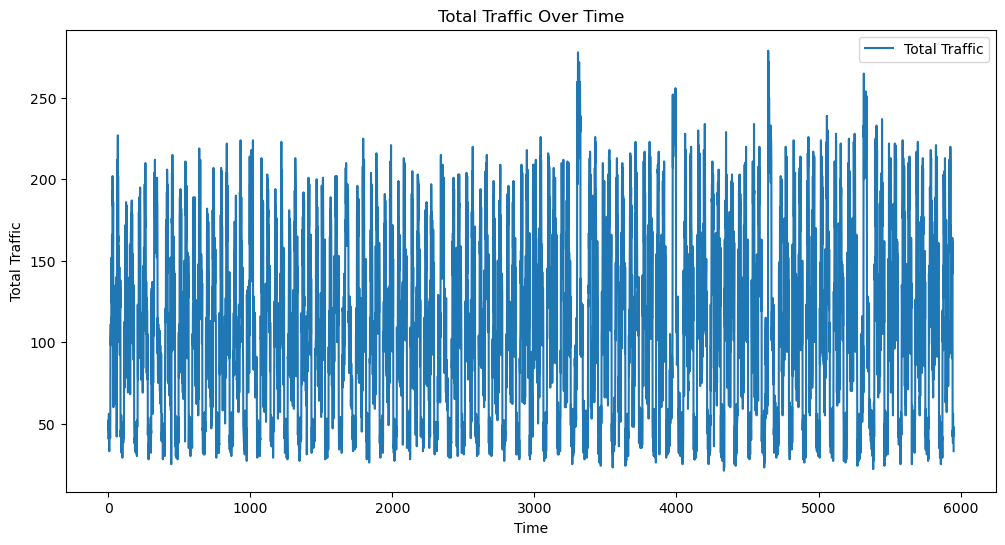

In [23]:
# Visualize the data
import matplotlib.pyplot as plt

# Plot the total traffic over time
plt.figure(figsize=(12, 6))
plt.plot(df['Total'], label='Total Traffic')
plt.xlabel('Time')
plt.ylabel('Total Traffic')
plt.title('Total Traffic Over Time')
plt.legend()
plt.show()


In [8]:
def prepare_data(data_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(data_path)
    
    # Convert `Traffic Situation` to categorical data type
    df['Traffic Situation'] = df['Traffic Situation'].astype('category')
    
    # Create numerical mapping for traffic situations
    new_category_mapping = {category: i for i, category in enumerate(df['Traffic Situation'].cat.categories)}
    df['Traffic Situation Num'] = df['Traffic Situation'].map(new_category_mapping)
    
    # One-hot encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder.fit_transform(df[['Day of the week']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Day of the week']))
    
    # Scale numerical features
    scaler = MinMaxScaler()
    numerical_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Combine features
    X = pd.concat([df[['Time', 'Date'] + numerical_features], encoded_df], axis=1)
    
    # Convert Time to seconds since midnight
    X['Time'] = X['Time'].apply(convert_time_to_seconds)
    
    return X, df['Traffic Situation Num'], df['Total']

In [9]:
def convert_time_to_seconds(time_str):
    time_part, meridiem = time_str.split(' ')
    hours, minutes, seconds = map(int, time_part.split(':'))
    
    if meridiem == 'PM' and hours != 12:
        hours += 12
    elif meridiem == 'AM' and hours == 12:
        hours = 0
        
    return hours * 3600 + minutes * 60 + seconds

In [10]:
class TrafficDataset(Dataset):
    def __init__(self, X, y_traffic_situation, y_total):
        self.X = torch.tensor(X.values, dtype=torch.float32).unsqueeze(1)
        self.y_traffic_situation = torch.tensor(y_traffic_situation.values, dtype=torch.long)
        self.y_total = torch.tensor(y_total.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_traffic_situation[idx], self.y_total[idx]

In [11]:
def train_model(model, train_loader, test_loader, num_epochs, device):
    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Loss functions
    criterion_classification = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_regression = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        anneal_strategy='cos'
    )
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        total_loss = 0
        
        for i, (inputs, labels_classification, labels_regression) in enumerate(pbar):
            inputs = inputs.to(device)
            labels_classification = labels_classification.to(device)
            labels_regression = labels_regression.to(device)

            optimizer.zero_grad()
            outputs_classification, outputs_regression = model(inputs)
            
            loss_classification = criterion_classification(outputs_classification, labels_classification)
            loss_regression = criterion_regression(outputs_regression.squeeze(), labels_regression)
            loss = loss_classification * 0.7 + loss_regression * 0.3
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{total_loss/(i+1):.4f}'})
    
    # Evaluation
    evaluate_model(model, test_loader, device)

In [12]:
def evaluate_model(model, test_loader, device):
    model.eval()
    criterion_regression = nn.MSELoss()
    
    with torch.no_grad():
        correct_classification = 0
        total_classification = 0
        total_loss_regression = 0
        
        pbar = tqdm(test_loader, desc='Evaluating')
        
        for inputs, labels_classification, labels_regression in pbar:
            inputs = inputs.to(device)
            labels_classification = labels_classification.to(device)
            labels_regression = labels_regression.to(device)

            outputs_classification, outputs_regression = model(inputs)
            _, predicted_classification = torch.max(outputs_classification.data, 1)
            total_classification += labels_classification.size(0)
            correct_classification += (predicted_classification == labels_classification).sum().item()
            loss_regression = criterion_regression(outputs_regression.squeeze(), labels_regression)
            total_loss_regression += loss_regression.item()
            
            current_accuracy = 100 * correct_classification / total_classification
            current_loss = total_loss_regression / (pbar.n + 1)
            pbar.set_postfix({
                'Accuracy': f'{current_accuracy:.2f}%',
                'Reg Loss': f'{current_loss:.4f}'
            })

        accuracy_classification = 100 * correct_classification / total_classification
        avg_loss_regression = total_loss_regression / len(test_loader)

        print(f"\nFinal Results:")
        print(f"Accuracy (Classification): {accuracy_classification:.2f}%")
        print(f"Average Loss (Regression): {avg_loss_regression:.4f}")


In [13]:
data_path = "TrafficTwoMonth.csv"
input_size = 14  # Will be determined from data
hidden_size = 256
num_layers = 4
num_classes = 4
global learning_rate
learning_rate = 0.001
num_epochs = 50
batch_size = 32

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare data
print("Preparing data...")
X, y_traffic_situation, y_total = prepare_data(data_path)

# Split data
X_train, X_test, y_traffic_situation_train, y_traffic_situation_test, y_total_train, y_total_test = \
    train_test_split(X, y_traffic_situation, y_total, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = TrafficDataset(X_train, y_traffic_situation_train, y_total_train)
test_dataset = TrafficDataset(X_test, y_traffic_situation_test, y_total_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = TrafficLSTM(input_size, hidden_size, num_layers, num_classes)
model = model.to(device)

# Train model
print("Starting training...")
train_model(model, train_loader, test_loader, num_epochs, device)

# Save the model
torch.save(model.state_dict(), 'traffic_lstm_model.pth')
print("Model saved to 'traffic_lstm_model.pth'")


Using device: mps
Preparing data...
Starting training...


Evaluating: 100%|██████████| 38/38 [00:00<00:00, 181.54it/s, Accuracy=93.87%, Reg Loss=0.0060]



Final Results:
Accuracy (Classification): 93.87%
Average Loss (Regression): 0.0038
Model saved to 'traffic_lstm_model.pth'
